In [2]:
%matplotlib inline
import sys,os,time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.ndimage
from skimage.io import imread, imsave
from skimage.transform import rotate

import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
df = pd.read_csv("./data/train_df.csv", index_col=0, )

In [3]:
NUM_WORKERS = 8
NUM_CHIPS_PER_TILE = 8
CHIP_SIZE = 256
LARGE_CHIP_SIZE = int(np.ceil(CHIP_SIZE * np.sqrt(2)))
CROP_POINT = (LARGE_CHIP_SIZE - CHIP_SIZE) // 2

PADDING = 32
assert PADDING % 2 == 0
HALF_PADDING = PADDING//2
CHIP_STRIDE = CHIP_SIZE - PADDING

In [5]:
LARGE_CHIP_SIZE

363

In [6]:
df.shape

(155487, 1)

In [7]:
data_root_dir = "./data"

In [24]:
segmentation_df = pd.read_csv('./data/train_ship_segmentations_v2.csv').set_index('ImageId')

In [25]:
tr_n = np.array(pd.read_csv('./data/train_df.csv')['0'].reset_index(drop=True))

In [26]:
len(tr_n)

155487

In [27]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']

for el in exclude_list:
    if(el in tr_n): tr_n.remove(el)
        
        
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)

In [33]:
len(tr_n)

34376

In [9]:
len(image_fns)

155487

In [35]:
len(image_fns) == len(mask_fns) == len(mask_id_fns)

True

In [39]:
len(np.unique(image_fns))

34376

In [34]:
image_fns = [
    os.path.join(data_root_dir, "train_v2/", fn)
    for fn in tr_n
]

mask_fns = [
    os.path.join(data_root_dir, "train_v2_masks/", fn.replace(".jpg", ".png"))
    for fn in tr_n
]

mask_id_fns = [
    os.path.join(data_root_dir, "train_v2_mask_ids/", fn.replace(".jpg", ".png"))
    for fn in tr_n
]

In [8]:
image_fns.index("./data/train_v2/000194a2d.jpg")

131961

In [9]:
image_fns[0]

'./data/train_v2/2433a1622.jpg'

In [10]:
class AirbusShipDataset(Dataset):

    def __init__(self, fn, data_root_dir, transform=None):
        df = pd.read_csv(fn)
        
        self.image_fns = [
            os.path.join(data_root_dir, "train_v2/", fn)
            for fn in df["0"].values
        ]

        self.mask_fns = [
            os.path.join(data_root_dir, "train_v2_masks/", fn.replace(".jpg", ".png"))
            for fn in df["0"].values
        ]

        self.mask_id_fns = [
            os.path.join(data_root_dir, "train_v2_mask_ids/", fn.replace(".jpg", ".png"))
            for fn in df["0"].values
        ]
        
        self.mask_exists = [
            os.path.exists(fn)
            for fn in self.mask_fns
        ]
        
        self.transform = transform

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, idx):

        img_fn, mask_fn, mask_id_fn = self.image_fns[idx], self.mask_fns[idx], self.mask_id_fns[idx]
        fn = os.path.basename(img_fn)
        
        
        image = imread(img_fn)
        if self.mask_exists[idx]:
            mask = imread(mask_fn)
            mask_id = imread(mask_id_fn)
        else:
            mask = np.zeros((768, 768), dtype=np.uint8)
            mask_id = np.zeros((768, 768), dtype=np.uint8)
        
        #if self.transform:
        #    sample = self.transform(sample)

        return (image, mask, mask_id, fn)

In [10]:
def joint_transform(img, labels, rotation_augmentation=True):
    if rotation_augmentation:
        rotate_amount = np.random.randint(0,360)
        img = rotate(img, rotate_amount)
        labels = rotate(labels, rotate_amount, order=0)
        labels = (labels * 255).astype(np.uint8)

        img = img[CROP_POINT:CROP_POINT+CHIP_SIZE, CROP_POINT:CROP_POINT+CHIP_SIZE]
        labels = labels[CROP_POINT:CROP_POINT+CHIP_SIZE, CROP_POINT:CROP_POINT+CHIP_SIZE]
    else:
        img = img / 255.0

        img = img[CROP_POINT:CROP_POINT+CHIP_SIZE, CROP_POINT:CROP_POINT+CHIP_SIZE]
        labels = labels[CROP_POINT:CROP_POINT+CHIP_SIZE, CROP_POINT:CROP_POINT+CHIP_SIZE]
        
    img = np.rollaxis(img, 2, 0).astype(np.float32)
    img = torch.from_numpy(img)
    labels = labels.astype(np.int64)
    labels = torch.from_numpy(labels)

    return img, labels

In [12]:
train_dataset = AirbusShipDataset("./data/train_df.csv", "./data")

In [13]:
(image, mask, mask_id, fn) = train_dataset[0]

In [14]:
image = image[:LARGE_CHIP_SIZE, :LARGE_CHIP_SIZE]
mask = mask[:LARGE_CHIP_SIZE, :LARGE_CHIP_SIZE]
mask_id = mask_id[:LARGE_CHIP_SIZE, :LARGE_CHIP_SIZE]

In [15]:
img, labels = joint_transform(image, mask, True)

In [16]:
img.dtype, img.shape

(torch.float32, torch.Size([3, 256, 256]))

In [17]:
img = np.moveaxis(np.array(img), 0, 2)

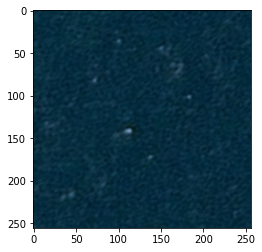

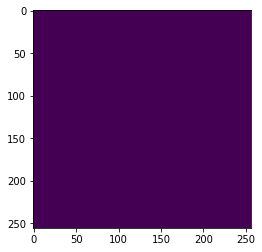

In [18]:
plt.figure()
plt.imshow(img)
plt.show()
plt.close()

plt.figure()
plt.imshow(labels)
plt.show()
plt.close()

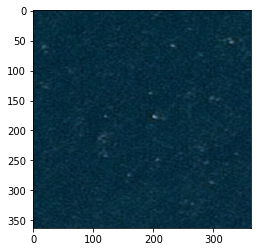

In [19]:
plt.imshow(image)

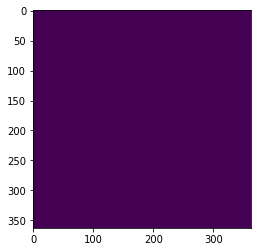

In [99]:
plt.figure()
plt.imshow(mask[:LARGE_CHIP_SIZE, :LARGE_CHIP_SIZE])
plt.show()
plt.close()

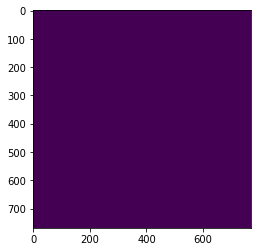

In [98]:
plt.figure()
plt.imshow(mask_id)
plt.show()
plt.close()

In [5]:
import joblib

In [6]:
ship_areas_by_fn = joblib.load("./data/ship_areas_by_fn.p")

In [41]:
ship_areas_by_fn[fn]

{1: 480, 2: 648, 3: 177, 4: 148, 5: 7}

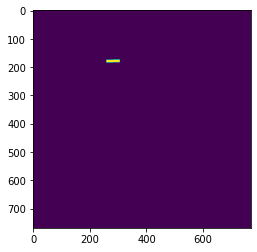

In [48]:
plt.figure()
plt.imshow(mask_id==1)
plt.show()
plt.close()

In [49]:
train_dataset

## Secondary dataset

Load 786x786 input images -> convert into 256x256 input batches

In [104]:
NUM_WORKERS = 8
NUM_CHIPS_PER_TILE = 8
CHIP_SIZE = 256
LARGE_CHIP_SIZE = int(np.ceil(CHIP_SIZE * np.sqrt(2)))
CROP_POINT = (LARGE_CHIP_SIZE - CHIP_SIZE) // 2

PADDING = 32
assert PADDING % 2 == 0
HALF_PADDING = PADDING//2
CHIP_STRIDE = CHIP_SIZE - PADDING

In [61]:
class AirbusShipPatchDataset(Dataset):
    
    """
        Returns 8 256x256 patches per tile
    """

    def __init__(self, fn, data_root_dir, large_chip_size=362, chip_size=256, 
                 transform=joint_transform, rotation_augmentation=False, give_mask_id=True):
        df = pd.read_csv(fn)
        
        self.image_fns = [
            os.path.join(data_root_dir, "train_v2/", fn)
            for fn in df["0"].values
        ]

        self.mask_fns = [
            os.path.join(data_root_dir, "train_v2_masks/", fn.replace(".jpg", ".png"))
            for fn in df["0"].values
        ]

        self.mask_id_fns = [
            os.path.join(data_root_dir, "train_v2_mask_ids/", fn.replace(".jpg", ".png"))
            for fn in df["0"].values
        ]
        
        self.mask_exists = [
            os.path.exists(fn)
            for fn in self.mask_fns
        ]
        
        self.transform = transform
        self.rotation_augmentation = rotation_augmentation
        self.large_chip_size = large_chip_size
        self.chip_size = chip_size
        self.give_mask_id = give_mask_id

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, idx):

        img_fn, mask_fn, mask_id_fn = self.image_fns[idx], self.mask_fns[idx], self.mask_id_fns[idx]
        fn = os.path.basename(img_fn)
        
        image = imread(img_fn)
        if self.mask_exists[idx]:
            mask = imread(mask_fn)
            mask_id = imread(mask_id_fn)
        else:
            mask = np.zeros((768, 768), dtype=np.uint8)
            mask_id = np.zeros((768, 768), dtype=np.uint8)
        
        res = []
        res_masks = []
        
        width, height, channel = image.shape
        
        # Extract patches
        for patch_i in range(8):
            # Select the top left pixel of our chip randomly
            x = np.random.randint(0, width-self.large_chip_size)
            y = np.random.randint(0, height-self.large_chip_size)

            # Read imagery / labels
            p_img = None
            p_mask = None
            p_mask_id = None

            p_img = image[y:y+self.large_chip_size, x:x+self.large_chip_size, :]
            p_mask = mask[y:y+self.large_chip_size, x:x+self.large_chip_size]
            p_mask_id = mask_id[y:y+self.large_chip_size, x:x+self.large_chip_size]
            
            if self.give_mask_id == True:
                if self.rotation_augmentation:
                    p_img, p_mask_id = self.transform(p_img, p_mask_id, rotation_augmentation=True)
                else:
                    p_img, p_mask_id = self.transform(p_img, p_mask_id, rotation_augmentation=False)

                assert p_img.shape == (3,256,256) and p_mask_id.shape == (256,256)

                res.append(p_img)
                res_masks.append(p_mask_id)
            else:
                if self.rotation_augmentation:
                    p_img, p_mask = self.transform(p_img, p_mask, rotation_augmentation=True)
                else:
                    p_img, p_mask = self.transform(p_img, p_mask, rotation_augmentation=False)

                assert p_img.shape == (3,256,256) and p_mask.shape == (256,256)

                res.append(p_img)
                res_masks.append(p_mask)

        return (image, mask, mask_id, fn, res, res_masks)

In [62]:
train_p_dataset = AirbusShipPatchDataset("./data/train_df.csv", "./data", 
                                         large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform,
                                         rotation_augmentation=True, give_mask_id=True)

In [63]:
(image, mask, mask_id, fn, res, res_masks) = train_p_dataset[7]

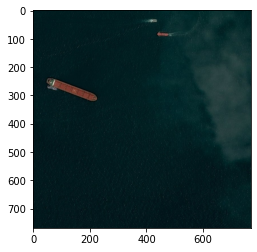

In [64]:
plt.imshow(image)

In [65]:
res[0].shape

torch.Size([3, 256, 256])

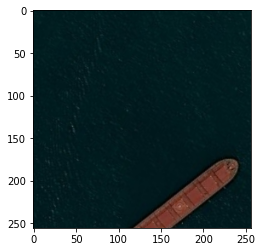

In [77]:
plt.imshow(np.moveaxis(np.array(res[4]), 0, -1))

In [78]:
np.unique(np.array(res_masks[4]))

array([0, 3])

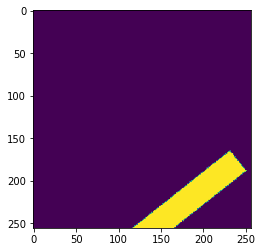

In [79]:
plt.imshow(res_masks[4])

In [8]:
from torch.utils.data import IterableDataset

In [64]:

class StreamingShipDataset(IterableDataset):
    
    def __init__(self, fn, data_root_dir, num_patches=8, chip_size=256, large_chip_size=362, 
                 transform=joint_transform, rotation_augmentation=False, give_mask_id=True, test=False, verbose = False):
        df = pd.read_csv(fn)
        
        self.num_patches = num_patches
        self.chip_size = chip_size
        self.large_chip_size = large_chip_size
        self.rotation_augmentation = rotation_augmentation
        self.give_mask_id = give_mask_id
        self.test = test
        self.verbose = verbose
        
        self.image_fns = [
            os.path.join(data_root_dir, "train_v2/", fn)
            for fn in df["0"].values
        ]

        self.mask_fns = [
            os.path.join(data_root_dir, "train_v2_masks/", fn.replace(".jpg", ".png"))
            for fn in df["0"].values
        ]

        self.mask_id_fns = [
            os.path.join(data_root_dir, "train_v2_mask_ids/", fn.replace(".jpg", ".png"))
            for fn in df["0"].values
        ]
        
        self.mask_exists = [
            os.path.exists(fn)
            for fn in self.mask_fns
        ]
                        
        self.transform = transform

    def stream_tile_fns(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None: # In this case we are not loading through a DataLoader with multiple workers
            worker_id = 0
            num_workers = 1
        else:
            worker_id = worker_info.id
            num_workers = worker_info.num_workers

        if self.verbose:
            print("Creating a filename stream for worker %d" % (worker_id))

        # This logic splits up the list of filenames into `num_workers` chunks. Each worker will recieve ceil(num_filenames / num_workers) filenames to generate chips from. If the number of workers doesn't divide the number of filenames evenly then the last worker will have fewer filenames.
        N = len(self.image_fns)
        num_files_per_worker = int(np.ceil(N / num_workers))
        lower_idx = worker_id * num_files_per_worker
        upper_idx = min(N, (worker_id+1) * num_files_per_worker)
        for idx in range(lower_idx, upper_idx):

            img_fn = self.image_fns[idx]
            mask_fn = self.mask_fns[idx]
            mask_id_fn = self.mask_id_fns[idx]

            if self.verbose:
                print("Worker %d, yielding file %d" % (worker_id, idx))

            yield (idx, img_fn, mask_fn, mask_id_fn)

    def stream_chips(self):
        for (idx, img_fn, mask_fn, mask_id_fn) in self.stream_tile_fns():
            num_skipped_chips = 0
            
            # Read images
            img_fp = imread(img_fn)
            
            if self.mask_exists[idx]:
                mask_fp = imread(mask_fn)
                mask_id_fp = imread(mask_id_fn)
            else:
                mask_fp = np.zeros((768, 768), dtype=np.uint8)
                mask_id_fp = np.zeros((768, 768), dtype=np.uint8)
            
            height, width, channel = img_fp.shape
            l_height, l_width = mask_fp.shape

            assert height == l_height and width == l_width
            
            # Randomly sample NUM_PATCHES from image
            
            for i in range(self.num_patches):
                # Select the top left pixel of our chip randomly
                x = np.random.randint(0, width-self.large_chip_size)
                y = np.random.randint(0, height-self.large_chip_size)

                # Read imagery / labels
                p_img = None
                p_mask = None
                p_mask_id = None
                
                p_img = img_fp[y:y+self.large_chip_size, x:x+self.large_chip_size, :]
                p_mask = mask_fp[y:y+self.large_chip_size, x:x+self.large_chip_size]
                p_mask_id = mask_id_fp[y:y+self.large_chip_size, x:x+self.large_chip_size]

                if self.test == True:
                    # Only return these for testing
                    orig = p_img

                    if self.rotation_augmentation:
                        p_img, p_mask_id = self.transform(p_img, p_mask_id, rotation_augmentation=True)
                    else:
                        p_img, p_mask_id = self.transform(p_img, p_mask_id, rotation_augmentation=False)

                    assert p_img.shape == (3,256,256) and p_mask_id.shape == (256,256)

                    yield orig, img_fn, p_img, p_mask_id
                else:
                    if self.give_mask_id == True:
                        if self.rotation_augmentation:
                            p_img, p_mask_id = self.transform(p_img, p_mask_id, rotation_augmentation=True)
                        else:
                            p_img, p_mask_id = self.transform(p_img, p_mask_id, rotation_augmentation=False)

                        assert p_img.shape == (3,256,256) and p_mask_id.shape == (256,256)

                        yield p_img, p_mask_id
                        
                    else:
                        if self.rotation_augmentation:
                            p_img, p_mask = self.transform(p_img, p_mask, rotation_augmentation=True)
                        else:
                            p_img, p_mask = self.transform(p_img, p_mask, rotation_augmentation=False)

                        assert p_img.shape == (3,256,256) and p_mask.shape == (256,256)

                        
                        yield p_img, p_mask
                

            if num_skipped_chips>0 and self.verbose:
                print("We skipped %d chips on %s" % (img_fn))

    def __iter__(self):
        if self.verbose:
            print("Creating a new StreamingGeospatialDataset iterator")
        return iter(self.stream_chips())


In [17]:
from streaming_dataloader import StreamingShipDataset
from utils import rle_decode, get_mask, joint_transform
import segmentation_models_pytorch as smp

In [18]:
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')


In [19]:
streaming_train_dataset = StreamingShipDataset("./data/train_df.csv", "./data", 
large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform, preprocessing_fn=preprocessing_fn,
rotation_augmentation=True, give_mask_id=False, only_ships=True)

train_loader = DataLoader(dataset=streaming_train_dataset, batch_size = 1, num_workers=4)

In [20]:
for i, (img, mask) in enumerate(train_loader):
    if i == 10: break
        
    plt.figure()
    plt.imshow(img)
    plt.show()
    plt.close()
    

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jason/anaconda3/envs/ai4e/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jason/anaconda3/envs/ai4e/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 28, in fetch
    data.append(next(self.dataset_iter))
  File "/home/jason/rotation/streaming_dataloader.py", line 182, in stream_chips
  File "/home/jason/anaconda3/envs/ai4e/lib/python3.8/site-packages/segmentation_models_pytorch/encoders/_preprocessing.py", line 17, in preprocess_input
    x = x - mean
ValueError: operands could not be broadcast together with shapes (3,256,256) (3,) 


('./data/train_v2/b19c65c9f.jpg', './data/train_v2/b19c65c9f.jpg', './data/train_v2/b19c65c9f.jpg', './data/train_v2/b19c65c9f.jpg', './data/train_v2/b19c65c9f.jpg', './data/train_v2/b19c65c9f.jpg', './data/train_v2/b19c65c9f.jpg', './data/train_v2/b19c65c9f.jpg')


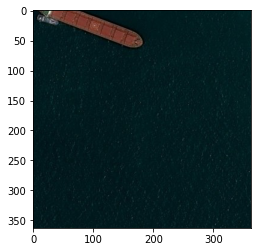

TypeError: Invalid shape (256, 3, 256) for image data

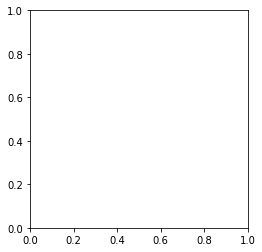

In [13]:
for i, (orig, fn, img, mask) in enumerate(loader):
    if i == 100: break
    
    for m in range(len(mask)):
        if mask[m].sum() != 0:
            print(fn)
            plt.figure()
            plt.imshow(orig[m])
            plt.show()
            plt.close()

            plt.figure()
            plt.imshow(np.moveaxis(np.array(img[m]), 0, -1))
            plt.show()
            plt.close()

            plt.figure()
            plt.imshow(mask[m])
            plt.show()
            plt.close()

        

In [71]:
all(x==fn[0] for x in fn)

True